# Flower classifier using DenseNet and transfer learning

The goal of this project is to create a flower classifier by performing transfer learning and then fine tuning pretrained DenseNet model.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import nn
from collections import OrderedDict
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns
import torchvision.models 
import albumentations 
import torch
import os

## Dataset

In this project we will use dataset which contains 4242 images of flowers from 5 different classes:

- chamomile 
- tulip
- rose
- sunflower
- dandelion

First let's split dataset into training dataset (50%), validation dataset (20%) an test dataset (30%).
We will do this using a tool callled split-folders.

In [2]:
!pip install -q split-folders
!splitfolders --output /kaggle/tmp/flowers_dataset --ratio .5 .2 .3 -- ../input/flowers-recognition/flowers
!rm -r /kaggle/tmp/flowers_dataset/train/flowers /kaggle/tmp/flowers_dataset/val/flowers /kaggle/tmp/flowers_dataset/test/flowers 

Copying files: 4326 files [00:18, 239.36 files/s]


Now let's create datasets and define agumentations that will be used for training dataset.

In [3]:
class AlbumentationTransforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        x = np.array(x)
        return self.transforms(image=x)["image"]

dataset_root = "/kaggle/tmp/flowers_dataset"

agumentations = albumentations.Compose([
    albumentations.Downscale(scale_min=0.6, scale_max=0.99, p=0.2),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.1),
    albumentations.RandomFog(fog_coef_lower=0.1,
                             fog_coef_upper=0.5, alpha_coef=0.05, p=0.5),
    albumentations.RandomBrightnessContrast(),
    albumentations.RandomGamma(gamma_limit=(50, 150), p=0.4),
    albumentations.OpticalDistortion(p=0.2),
    albumentations.Blur(blur_limit=2, p=0.2)
])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    AlbumentationTransforms(agumentations),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

test_val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

train_dataset = ImageFolder(os.path.join(dataset_root, "train"),
                            transform=train_transforms)
val_dataset = ImageFolder(os.path.join(dataset_root, "val"),
                          transform=test_val_transforms)
test_dataset = ImageFolder(os.path.join(dataset_root, "test"),
                          transform=test_val_transforms)

Now let's visualize agumented data and make histogram of classes.

In [4]:
def image_to_numpy(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnormalize = transforms.Normalize((-mean / std), (1.0 / std))
    image = unnormalize(image).numpy()
    return np.transpose(image, (1, 2, 0))
    
ldr = DataLoader(train_dataset, batch_size=10, shuffle=True)

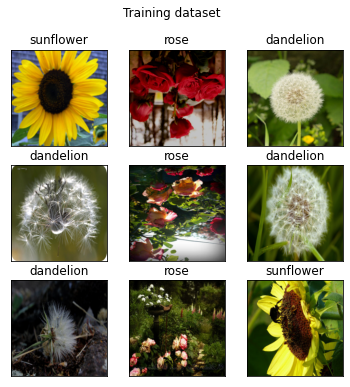

In [5]:
x, y = next(iter(ldr))
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(6, 6),
                       subplot_kw={"xticks": [], "yticks": []})

fig.suptitle("Training dataset")
for i, ax in enumerate(axs.flat):
    ax.set_title(train_dataset.classes[y[i]])
    ax.imshow(image_to_numpy(x[i]))

Now let's plot histogram of samples to make sure that dataset is reasonably well balanced.
Due to way datasets were sampled, distribution is the same in all sets so we will plot it only from training dataset.

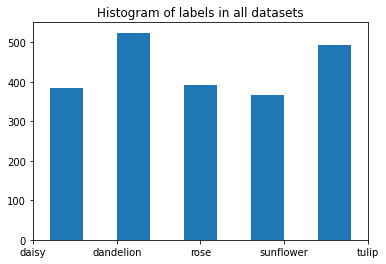

In [6]:
ldr = DataLoader(train_dataset, batch_size=len(train_dataset))
_, y = next(iter(ldr))
plt.title("Histogram of labels in all datasets")
plt.hist(y.numpy(), bins=len(train_dataset.classes), rwidth=0.5)
_ = plt.xticks(range(len(train_dataset.classes)), train_dataset.classes)

Dataset is reasonably well balanced so let's proceed to training.

## Model

Because this dataset is relatively small we will use transfer learning and fine tunning to obtain better results compared to direct training.
During my experiments I determined that from pretrained models in torchvision.models, the best base model for this particular task seem to be 
densenet-201.

We will prepare the pretrained model by:

- Replacing classification layer with a multilayer perceptron
- Disabling gradient computation for base model.
- Setting base model to the inference mode (so batch normalization will not be updated).

We will also add dropout to the linear layer because model is overfitting despite agumentation.

In [7]:
base_model = torchvision.models.densenet201(pretrained=True)
base_model.classifier = nn.Identity()

for param in base_model.parameters():
    param.requires_grad = False

model = nn.Sequential(OrderedDict([
    ("base_model", base_model),
    ("classifier", nn.Sequential(nn.Dropout(p=0.5), nn.Linear(1920, 5)))
]))

model.base_model = model.base_model.eval()

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

## Transfer learning

Now we will train linear classification layer.

In [8]:
def accuracy(preds, labels):
    cmp = preds == labels
    return float(cmp.sum())/len(labels)

def train_epoch(model, loader, optimizer, criterion, device):
    model.classifier.train()
    losses = []
    labels = np.array([])
    preds = np.array([])

    for x, y in loader:
        labels = np.append(labels, y.detach().numpy())
        x = x.to(device)
        y = y.to(device)

        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = y_hat.argmax(axis=1)
            y_hat = y_hat.cpu().numpy()
            preds = np.append(preds, y_hat)
            losses.append(loss.cpu())

    return np.average(losses), accuracy(preds, labels)

def evaluate(model, loader, criterion, device):
    model.classifier.eval()
    losses = []
    labels = np.array([])
    preds = np.array([])

    for x, y in loader:
        with torch.no_grad():
            labels = np.append(labels, y.detach().numpy())
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)
            losses.append(loss.cpu())

            y_hat = y_hat.argmax(axis=1)
            y_hat = y_hat.cpu().numpy()
            preds = np.append(preds, y_hat)

    return np.average(losses), accuracy(preds, labels), preds, labels

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 256
epochs = 20

From experiments I determined that RMSprop seem to be the best suited for this task. We will set very low learning rate as model has a tendency to be unstable during training.

In [10]:
val_loader = DataLoader(val_dataset, num_workers=6, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, num_workers=6, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()
model = model.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)

In [11]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _,_ = evaluate(model, val_loader, criterion, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    print(f"epoch {epoch+1}/{epochs}: loss: {train_loss}, val_loss: {val_loss}, acc: {train_acc}, val_acc: {val_acc}")
    
clear_output()

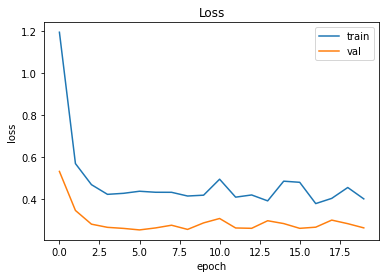

In [12]:
plt.title("Loss")
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

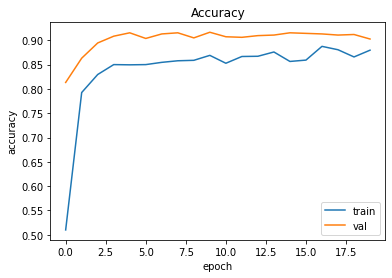

In [13]:
plt.title("Accuracy")
plt.plot(train_acc_history, label="train")
plt.plot(val_acc_history, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

We get ~91% of accuracy from transfer learning. Now let's see whether we can improve our model further by fine tuning the base model.

## Fine tuning

Now let's unlock dense block 4 and fine tune it. For this step classifier layer will be locked and set to inference mode.

In [14]:
model.classifier.eval()

for param in model.classifier.parameters():
    param.requires_grad = False

for param in model.base_model.features.denseblock4.parameters():
    param.requires_grad = True

Optimizer for this model will be 

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.00005)
epochs = 20

In [16]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    print(f"epoch {epoch+1}/{epochs}: loss: {train_loss}, val_loss: {val_loss}, acc: {train_acc}, val_acc: {val_acc}")
    
clear_output()

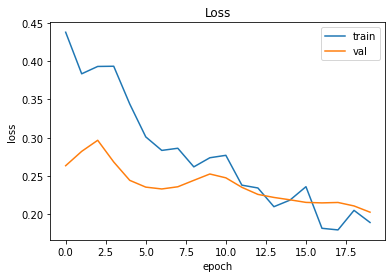

In [17]:
plt.title("Loss")
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

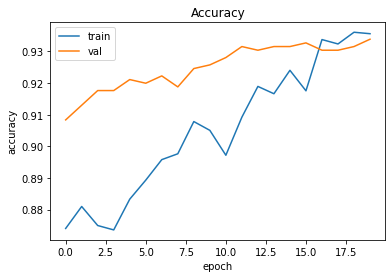

In [18]:
plt.title("Accuracy")
plt.plot(train_acc_history, label="train")
plt.plot(val_acc_history, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

As we can see we gain around ~2% of accuracy by performing fine tuning.

## Evaluation

Now let's evaluate performance of the model on a test set.

In [19]:
model.eval()
test_loader = DataLoader(test_dataset, num_workers=6, batch_size=256, shuffle=False)
test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)

In [20]:
test_loss

0.21220636

In [21]:
test_acc

0.9208909370199693

In [22]:
def plot_confusion_matrix(preds, labels, annotations, round_to=2):
    mat = confusion_matrix(labels, preds)
    mat =  mat.astype("float") / mat.sum(axis=1)[:, np.newaxis]
    mat = np.round(mat, round_to)

    sns.heatmap(mat, annot=True, xticklabels=annotations,
            yticklabels=annotations)

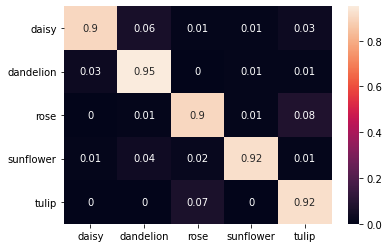

In [23]:
plot_confusion_matrix(preds, labels, test_dataset.classes)

As we can see the classifier has quite decent accuracy.

Also we can see the the best classification accuracy corresponds to the classes that had the most samples.